In [ ]:
!pip install opencv-python

In [ ]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qzue1dnt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qzue1dnt
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install compel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
from skimage.feature import hog
import cv2

class Copy2PromptPipeline:
    def __init__(self, analyzer, generator):
        self.analyzer = analyzer
        self.generator = generator

    def process_image(
        self,
        image: Image.Image,
        custom_prompt: str = None,
        num_variations: int = 1,
        seed: int = None,
        num_inference_steps=40,
        guidance_scale=7.5,
        max_tokens=512,
    ) -> dict:
        print("Step 1: Analyzing image with LLaVA...")
        detailed_prompt = self.analyzer.analyze_image(
            image, custom_prompt, max_tokens=max_tokens
        )
        print(f"Generated prompt: {detailed_prompt}")

        print(f"Step 2: Generating {num_variations} image variation(s) with SDXL...")
        generated_images = []

        for i in range(num_variations):
            variation_seed = seed + i if seed is not None else None
            generated_image = self.generator.generate_image(
                prompt=detailed_prompt,
                seed=variation_seed,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
            )
            generated_images.append(generated_image)
            print(f"Generated variation {i+1}/{num_variations}")

        return {
            "original_image": image,
            "generated_prompt": detailed_prompt,
            "generated_images": generated_images,
        }

    def calculate_image_similarity(self, img1: Image.Image, img2: Image.Image) -> dict:
        """Calculate selected similarity metrics between two images"""

        # Convert PIL images to numpy arrays
        img1_array = np.array(img1.convert('RGB'))
        img2_array = np.array(img2.convert('RGB'))

        # Resize images to same size for comparison
        target_size = (256, 256)
        img1_resized = cv2.resize(img1_array, target_size)
        img2_resized = cv2.resize(img2_array, target_size)

        # Convert to grayscale for some metrics
        img1_gray = cv2.cvtColor(img1_resized, cv2.COLOR_RGB2GRAY)
        img2_gray = cv2.cvtColor(img2_resized, cv2.COLOR_RGB2GRAY)

        scores = {}

        # 1. Structural Similarity Index (SSIM)
        ssim_score = ssim(img1_gray, img2_gray, data_range=255)
        scores['ssim'] = ssim_score

        # 2. Multi-Scale SSIM (MS-SSIM)
        ms_ssim = self._calculate_ms_ssim(img1_gray, img2_gray)
        scores['ms_ssim'] = ms_ssim

        # 3. Mean Squared Error (lower is better)
        mse = np.mean((img1_resized.astype(float) - img2_resized.astype(float)) ** 2)
        scores['mse'] = mse

        # 4. LAB color space similarity
        img1_lab = cv2.cvtColor(img1_resized, cv2.COLOR_RGB2LAB)
        img2_lab = cv2.cvtColor(img2_resized, cv2.COLOR_RGB2LAB)
        lab_diff = np.mean(np.sqrt(np.sum((img1_lab.astype(float) - img2_lab.astype(float))**2, axis=2)))
        lab_similarity = max(0, 1 - (lab_diff / 100))  # Normalize to 0-1
        scores['lab_similarity'] = lab_similarity

        # 5. HOG feature similarity
        try:
            hog1 = hog(img1_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
            hog2 = hog(img2_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
            hog_similarity = cosine_similarity([hog1], [hog2])[0][0]
            scores['hog_similarity'] = hog_similarity
        except:
            scores['hog_similarity'] = 0.0

        # 6. Histogram correlation (bonus metric)
        hist1 = cv2.calcHist([img1_resized], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256])
        hist2 = cv2.calcHist([img2_resized], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256])
        hist_correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
        scores['hist_correlation'] = hist_correlation

        # Overall similarity score (weighted combination)
        overall_score = (
            0.25 * ssim_score +
            0.20 * ms_ssim +
            0.20 * lab_similarity +
            0.15 * hog_similarity +
            0.10 * hist_correlation +
            0.10 * (1 - min(1.0, mse / 10000))  # Normalize MSE (lower is better)
        )
        scores['overall_similarity'] = overall_score

        return scores

    def _calculate_ms_ssim(self, img1, img2, weights=[0.0448, 0.2856, 0.3001, 0.2363, 0.1333]):
        """Multi-Scale SSIM calculation"""
        levels = len(weights)
        mssim = []

        for i in range(levels):
            ssim_val = ssim(img1, img2, data_range=255)
            mssim.append(ssim_val)

            if i < levels - 1:
                img1 = cv2.resize(img1, (img1.shape[1]//2, img1.shape[0]//2))
                img2 = cv2.resize(img2, (img2.shape[1]//2, img2.shape[0]//2))

        return np.prod([mssim[i]**weights[i] for i in range(levels)])

    def display_results(self, results: dict):
        original_image = results["original_image"]
        generated_images = results["generated_images"]
        num_images = len(generated_images)

        # Calculate similarity scores
        similarity_scores = []
        for i, gen_img in enumerate(generated_images):
            scores = self.calculate_image_similarity(original_image, gen_img)
            similarity_scores.append(scores)

        # Create subplot layout
        cols = min(3, num_images + 1)
        rows = (num_images + 1 + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        if rows == 1:
            axes = axes.reshape(1, -1)

        # Display original image
        axes[0, 0].imshow(original_image)
        axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold')
        axes[0, 0].axis("off")

        # Display generated images with similarity scores
        for i, (img, scores) in enumerate(zip(generated_images, similarity_scores)):
            row = (i + 1) // cols
            col = (i + 1) % cols

            axes[row, col].imshow(img)

            # Create title with similarity score
            title = f"Variation {i+1}\nSimilarity: {scores['overall_similarity']:.3f}"
            axes[row, col].set_title(title, fontsize=10)
            axes[row, col].axis("off")

            # Add detailed scores as text below image
            score_text = f"SSIM: {scores['ssim']:.3f}\nLAB: {scores['lab_similarity']:.3f}"
            axes[row, col].text(0.5, -0.1, score_text,
                              transform=axes[row, col].transAxes,
                              ha='center', va='top', fontsize=8)

        # Hide unused subplots
        for i in range(num_images + 1, rows * cols):
            row = i // cols
            col = i % cols
            axes[row, col].axis("off")

        plt.tight_layout()
        plt.show()

        # Display detailed similarity analysis
        print("\n" + "="*70)
        print("IMAGE SIMILARITY ANALYSIS")
        print("="*70)

        # Rank variations by overall similarity
        ranked_variations = sorted(enumerate(similarity_scores),
                                 key=lambda x: x[1]['overall_similarity'],
                                 reverse=True)

        print(f"\nRANKING (Best to Worst Similarity to Original):")
        print("-" * 50)
        for rank, (var_idx, scores) in enumerate(ranked_variations, 1):
            print(f"{rank}. Variation {var_idx + 1}: {scores['overall_similarity']:.4f}")

        print(f"\nDETAILED SIMILARITY METRICS:")
        print("-" * 50)
        for i, scores in enumerate(similarity_scores):
            print(f"\nVariation {i+1}:")
            print(f"  • Overall Similarity:    {scores['overall_similarity']:.4f}")
            print(f"  • SSIM (Structure):      {scores['ssim']:.4f}")
            print(f"  • MS-SSIM (Multi-Scale): {scores['ms_ssim']:.4f}")
            print(f"  • LAB Color Similarity:  {scores['lab_similarity']:.4f}")
            print(f"  • HOG Feature Similarity:{scores['hog_similarity']:.4f}")
            print(f"  • Histogram Correlation: {scores['hist_correlation']:.4f}")
            print(f"  • MSE (Error):           {scores['mse']:.2f}")

        # Provide interpretation
        print(f"\nINTERPRETATION GUIDE:")
        print("-" * 50)
        print("• Overall Similarity: 0.0 (no similarity) → 1.0 (identical)")
        print("• SSIM: Structural similarity (layout/composition)")
        print("• MS-SSIM: Multi-scale structural similarity")
        print("• LAB Similarity: Perceptually uniform color matching")
        print("• HOG Features: Shape and edge pattern similarity")
        print("• Histogram: Color distribution similarity")
        print("• MSE: Mean Squared Error (lower values = better match)")

        print("\nGenerated Prompt:")
        print("=" * 50)
        print(results["generated_prompt"])

        return similarity_scores

In [ ]:
!unzip Archive.zip

Archive:  Archive.zip
  inflating: WhatsApp Image 2025-06-11 at 21.36.48.jpeg  
  inflating: __MACOSX/._WhatsApp Image 2025-06-11 at 21.36.48.jpeg  
  inflating: WhatsApp Image 2025-06-11 at 21.36.49 (1).jpeg  
  inflating: __MACOSX/._WhatsApp Image 2025-06-11 at 21.36.49 (1).jpeg  
  inflating: WhatsApp Image 2025-06-11 at 21.36.49.jpeg  
  inflating: __MACOSX/._WhatsApp Image 2025-06-11 at 21.36.49.jpeg  
  inflating: WhatsApp Image 2025-06-11 at 21.36.48 (2).jpeg  
  inflating: __MACOSX/._WhatsApp Image 2025-06-11 at 21.36.48 (2).jpeg  
  inflating: WhatsApp Image 2025-06-11 at 21.36.48 (1).jpeg  
  inflating: __MACOSX/._WhatsApp Image 2025-06-11 at 21.36.48 (1).jpeg  


In [ ]:
!ls

 Archive.zip
 __MACOSX
 sample_data
'WhatsApp Image 2025-06-11 at 21.36.48 (1).jpeg'
'WhatsApp Image 2025-06-11 at 21.36.48 (2).jpeg'
'WhatsApp Image 2025-06-11 at 21.36.48.jpeg'
'WhatsApp Image 2025-06-11 at 21.36.49 (1).jpeg'
'WhatsApp Image 2025-06-11 at 21.36.49.jpeg'


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import clip
import random
import numpy as np

class PromptOptimizerAgent:
    def __init__(self, generator, reference_image, base_prompt: str, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.generator = generator
        self.reference_image = reference_image.convert('RGB')
        self.base_prompt = base_prompt
        self.device = device
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        self.quality_enhancers = [
            "highly detailed", "ultra realistic", "8k resolution", "masterpiece",
            "professional photography", "award winning", "trending on artstation",
            "hyperrealistic", "photorealistic", "studio quality", "crisp and clear",
            "sharp focus", "intricate details", "fine art quality"
        ]
        self.technical_specs = [
            "shot on Canon EOS R5", "85mm lens", "f/1.4 aperture", "shallow depth of field",
            "bokeh background", "long exposure", "HDR photography", "RAW format",
            "professional color grading", "film grain texture", "35mm film aesthetic",
            "medium format camera", "large format photography"
        ]
        self.composition_rules = [
            "rule of thirds", "leading lines", "symmetrical composition", "golden ratio",
            "diagonal composition", "frame within frame", "negative space",
            "central composition", "dynamic composition", "balanced composition",
            "asymmetrical balance", "radial composition"
        ]

    def mutate_prompt(self, prompt):
        """Add one enhancement from each category to the prompt"""
        quality = random.choice(self.quality_enhancers)
        technical = random.choice(self.technical_specs)
        composition = random.choice(self.composition_rules)
        return f"{prompt}, {quality}, {technical}, {composition}"

    def evaluate(self, image):
        """Use CLIP to compute similarity to the reference image"""
        image_input = self.preprocess(image).unsqueeze(0).to(self.device)
        ref_input = self.preprocess(self.reference_image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(image_input)
            ref_features = self.model.encode_image(ref_input)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        ref_features /= ref_features.norm(dim=-1, keepdim=True)

        similarity = (image_features @ ref_features.T).item()
        return similarity

    def run(self, iterations=5):
        current_prompt = self.base_prompt
        best_prompt = current_prompt
        best_image = None
        best_score = -float('inf')

        for i in range(iterations):
            print(f"\n[Iteration {i+1}]")
            new_prompt = self.mutate_prompt(current_prompt)
            print("📝 Prompt:", new_prompt)

            # Generate image
            image = self.generator.generate_image(
                prompt=new_prompt,
                seed=random.randint(0, 9999),
                num_inference_steps=40,
                guidance_scale=7.5
            )

            # Evaluate with CLIP
            score = self.evaluate(image)
            print(f" CLIP Similarity Score: {score:.4f}")

            if score > best_score:
                best_score = score
                best_prompt = new_prompt
                best_image = image

        return best_prompt, best_image, best_score

In [ ]:
import torch
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
from diffusers import StableDiffusionXLPipeline
from compel import Compel, ReturnedEmbeddingsType
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import os
from typing import List, Optional
import warnings
from pathlib import Path

class SDXLGenerator:
    def __init__(self, model_name="stabilityai/stable-diffusion-xl-base-1.0"):
        print(f"Loading SDXL model: {model_name}")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.pipeline = StableDiffusionXLPipeline.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            use_safetensors=True,
            variant="fp16" if torch.cuda.is_available() else None,
        )
        self.pipeline = self.pipeline.to(self.device)

        if torch.cuda.is_available():
            self.pipeline.enable_model_cpu_offload()
            self.pipeline.enable_vae_slicing()

        print(f"SDXL loaded on device: {self.device}")

        # Initialize Compel for handling long prompts
        self.compel = Compel(
            tokenizer=[self.pipeline.tokenizer, self.pipeline.tokenizer_2],
            text_encoder=[self.pipeline.text_encoder, self.pipeline.text_encoder_2],
            returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
            requires_pooled=[False, True],
        )
        print("✓ Compel initialized for long prompt support")

    def generate_image(
        self,
        prompt: str,
        negative_prompt: str = None,
        num_inference_steps: int = 40,
        guidance_scale: float = 9,
        width: int = 1024,
        height: int = 1024,
        seed: int = None,
    ) -> Image.Image:

        if negative_prompt is None:
            negative_prompt = (
                "blurry, low quality, distorted, deformed, bad anatomy, bad proportions"
            )

        generator = torch.Generator(device=self.device)
        if seed is not None:
            generator.manual_seed(seed)

        # Process prompts with Compel to handle long prompts
        conditioning, pooled = self.compel(prompt)
        negative_conditioning, negative_pooled = self.compel(negative_prompt)

        # Generate with embeddings instead of text
        with torch.no_grad():
            result = self.pipeline(
                prompt_embeds=conditioning,
                pooled_prompt_embeds=pooled,
                negative_prompt_embeds=negative_conditioning,
                negative_pooled_prompt_embeds=negative_pooled,
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                width=width,
                height=height,
                generator=generator,
            )

        return result.images[0]

In [ ]:
import requests
from io import BytesIO

In [ ]:
def load_image(path_or_url: str) -> Image.Image:
    if path_or_url.startswith("http"):
        response = requests.get(path_or_url)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(path_or_url)

    return image.convert("RGB")

In [ ]:
sample_image = load_image("car.jpeg")
generator = SDXLGenerator()

agent = PromptOptimizerAgent(generator, sample_image, base_prompt="A supercar")
best_prompt, best_image, best_score = agent.run(iterations=5)

print("\n Best Prompt:", best_prompt)
print("Best CLIP Score:", best_score)
best_image.show()

Loading SDXL model: stabilityai/stable-diffusion-xl-base-1.0


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SDXL loaded on device: cuda
✓ Compel initialized for long prompt support


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 286MiB/s]



[Iteration 1]
📝 Prompt: A supercar, award winning, f/1.4 aperture, symmetrical composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.6787

[Iteration 2]
📝 Prompt: A supercar, award winning, medium format camera, balanced composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.6465

[Iteration 3]
📝 Prompt: A supercar, highly detailed, long exposure, negative space


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.6650

[Iteration 4]
📝 Prompt: A supercar, professional photography, medium format camera, central composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.6689

[Iteration 5]
📝 Prompt: A supercar, hyperrealistic, shot on Canon EOS R5, radial composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.6968

 Best Prompt: A supercar, hyperrealistic, shot on Canon EOS R5, radial composition
Best CLIP Score: 0.69677734375


In [ ]:
sample_image = load_image("cat.jpeg")
agent = PromptOptimizerAgent(generator, sample_image, base_prompt="A cat")
best_prompt, best_image, best_score = agent.run(iterations=5)

print("\n Best Prompt:", best_prompt)
print("Best CLIP Score:", best_score)
best_image.show()


[Iteration 1]
📝 Prompt: A cat, crisp and clear, 35mm film aesthetic, symmetrical composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7749

[Iteration 2]
📝 Prompt: A cat, trending on artstation, shot on Canon EOS R5, symmetrical composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.8486

[Iteration 3]
📝 Prompt: A cat, professional photography, long exposure, radial composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7285

[Iteration 4]
📝 Prompt: A cat, photorealistic, long exposure, balanced composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.8394

[Iteration 5]
📝 Prompt: A cat, studio quality, medium format camera, dynamic composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.8682

 Best Prompt: A cat, studio quality, medium format camera, dynamic composition
Best CLIP Score: 0.8681640625


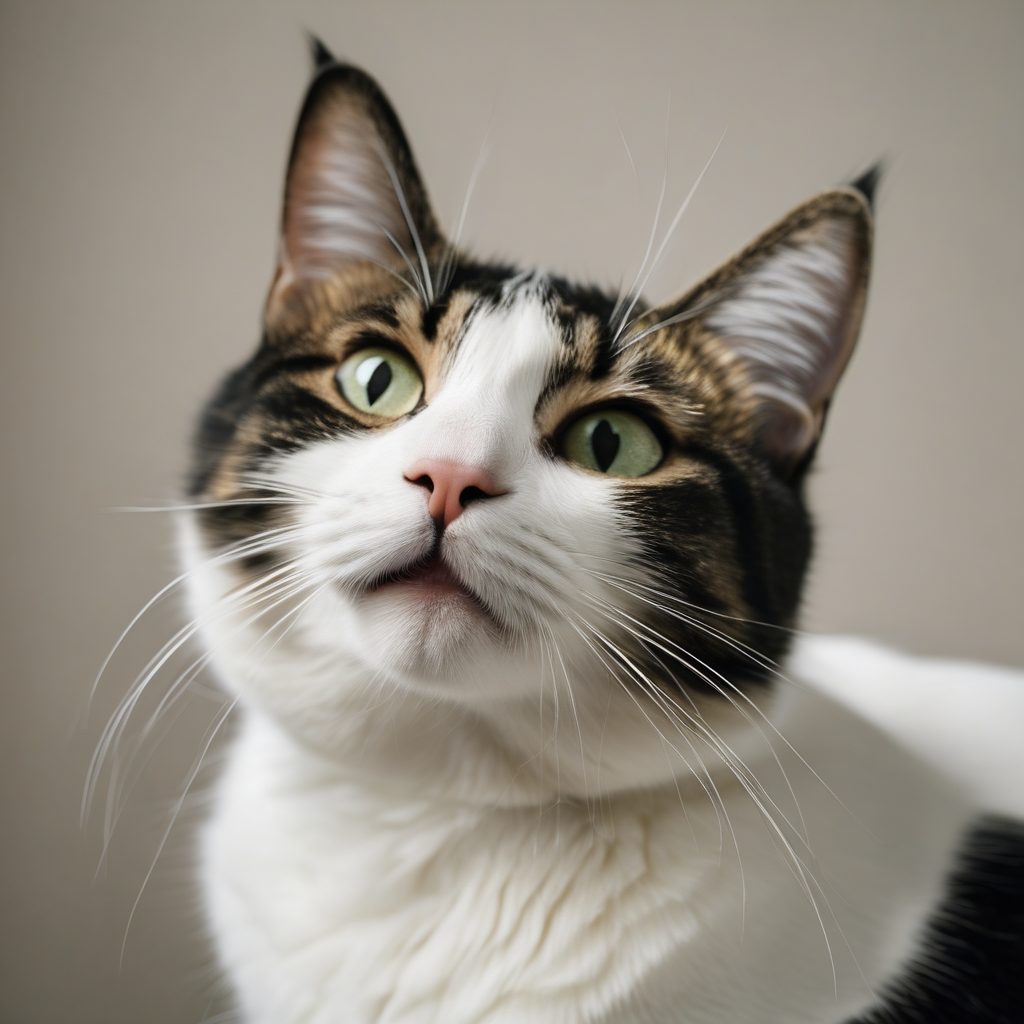

In [ ]:
best_image


[Iteration 1]
📝 Prompt: Book, sharp focus, shallow depth of field, central composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.5552

[Iteration 2]
📝 Prompt: Book, ultra realistic, long exposure, asymmetrical balance


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.5532

[Iteration 3]
📝 Prompt: Book, studio quality, large format photography, central composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.4202

[Iteration 4]
📝 Prompt: Book, crisp and clear, medium format camera, golden ratio


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.4565

[Iteration 5]
📝 Prompt: Book, hyperrealistic, professional color grading, golden ratio


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.3955

 Best Prompt: Book, sharp focus, shallow depth of field, central composition
Best CLIP Score: 0.55517578125


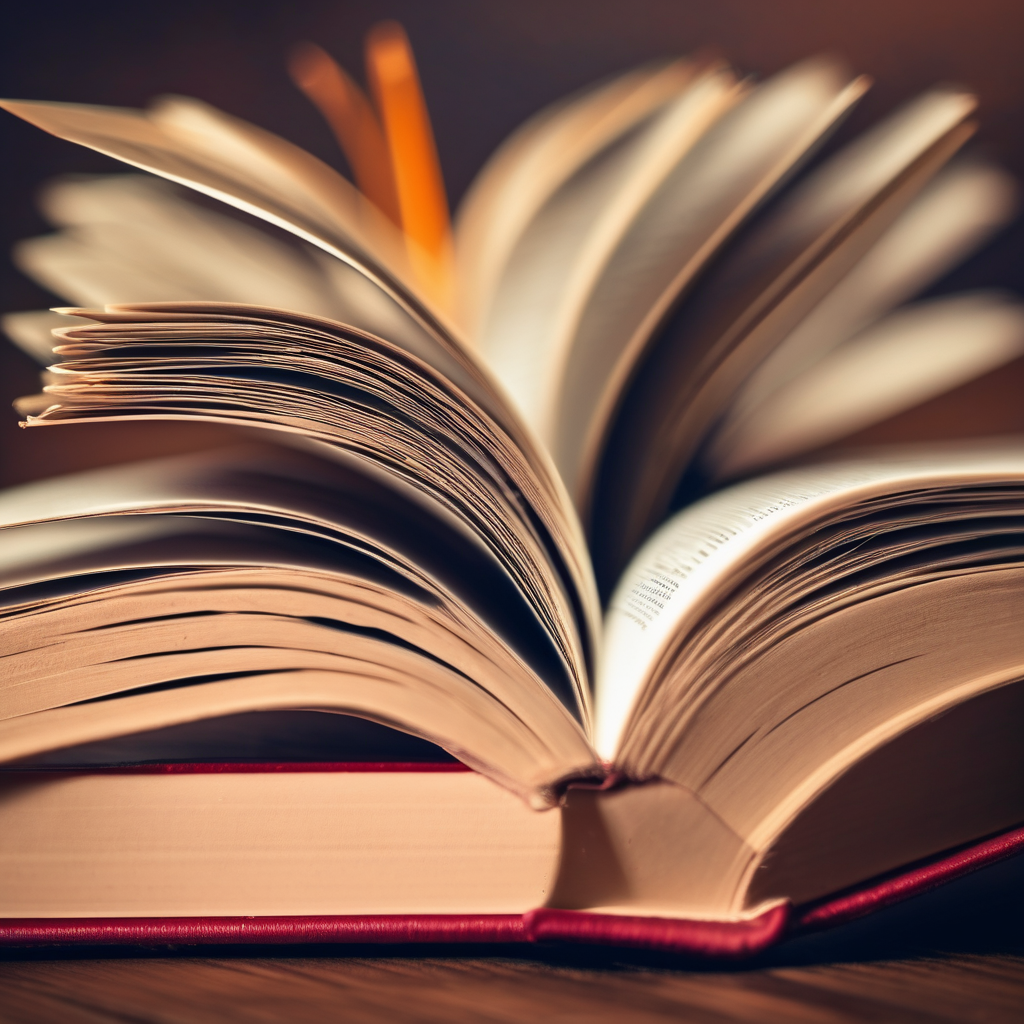

In [ ]:
sample_image = load_image("book.jpeg")
agent = PromptOptimizerAgent(generator, sample_image, base_prompt="Book")
best_prompt, best_image, best_score = agent.run(iterations=5)

print("\n Best Prompt:", best_prompt)
print("Best CLIP Score:", best_score)
best_image


[Iteration 1]
📝 Prompt: Lake, sharp focus, 85mm lens, leading lines


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7583

[Iteration 2]
📝 Prompt: Lake, ultra realistic, 85mm lens, central composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7378

[Iteration 3]
📝 Prompt: Lake, highly detailed, 35mm film aesthetic, symmetrical composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7622

[Iteration 4]
📝 Prompt: Lake, crisp and clear, medium format camera, dynamic composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7070

[Iteration 5]
📝 Prompt: Lake, masterpiece, shot on Canon EOS R5, central composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7119

 Best Prompt: Lake, highly detailed, 35mm film aesthetic, symmetrical composition
Best CLIP Score: 0.76220703125


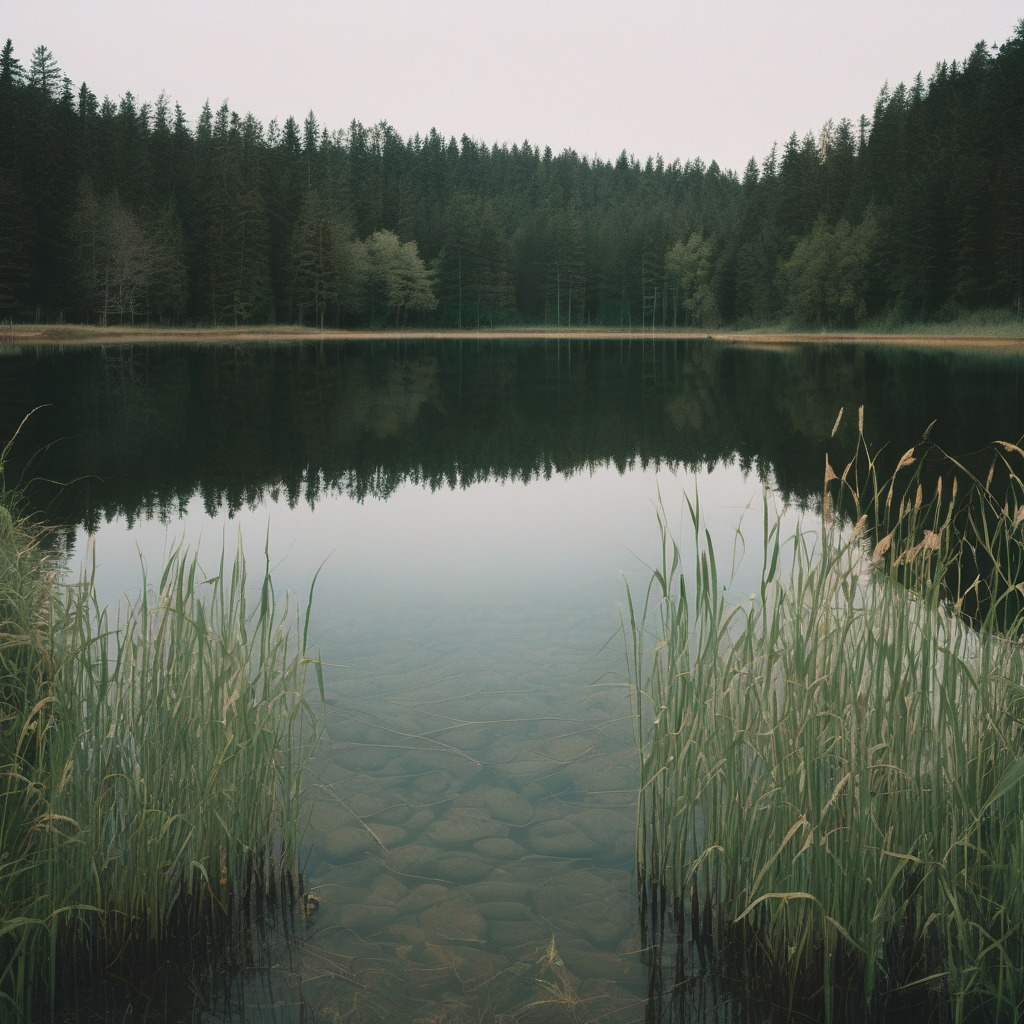

In [ ]:
sample_image = load_image("lake.jpeg")
agent = PromptOptimizerAgent(generator, sample_image, base_prompt="Lake")
best_prompt, best_image, best_score = agent.run(iterations=5)

print("\n Best Prompt:", best_prompt)
print("Best CLIP Score:", best_score)
best_image


[Iteration 1]
📝 Prompt: Sunset at the beach with a group of people, intricate details, shot on Canon EOS R5, balanced composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7515

[Iteration 2]
📝 Prompt: Sunset at the beach with a group of people, ultra realistic, long exposure, golden ratio


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7129

[Iteration 3]
📝 Prompt: Sunset at the beach with a group of people, fine art quality, film grain texture, leading lines


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7593

[Iteration 4]
📝 Prompt: Sunset at the beach with a group of people, award winning, bokeh background, diagonal composition


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.8228

[Iteration 5]
📝 Prompt: Sunset at the beach with a group of people, professional photography, f/1.4 aperture, negative space


  0%|          | 0/40 [00:00<?, ?it/s]

 CLIP Similarity Score: 0.7905

 Best Prompt: Sunset at the beach with a group of people, award winning, bokeh background, diagonal composition
Best CLIP Score: 0.82275390625


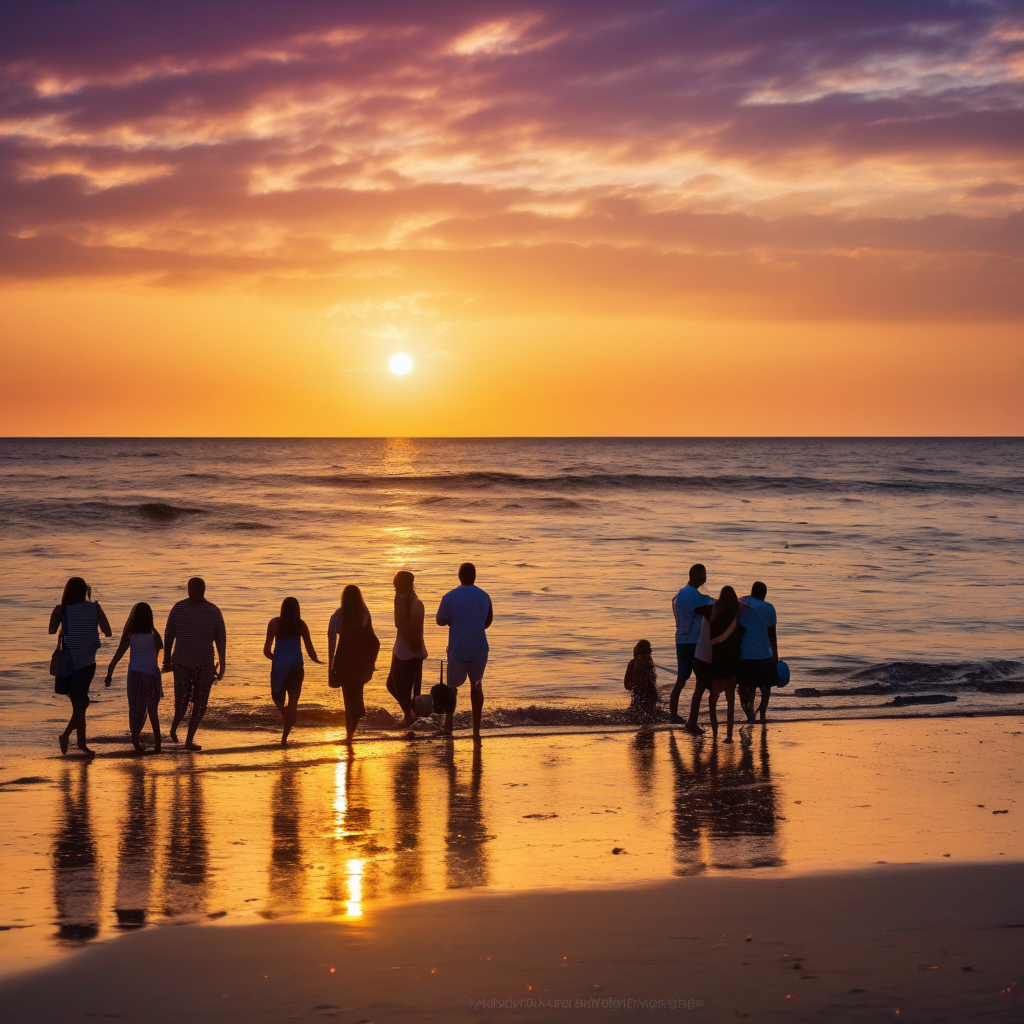

In [ ]:
sample_image = load_image("people.jpeg")
agent = PromptOptimizerAgent(generator, sample_image, base_prompt="Sunset at the beach with a group of people")
best_prompt, best_image, best_score = agent.run(iterations=5)

print("\n Best Prompt:", best_prompt)
print("Best CLIP Score:", best_score)
best_image